In [306]:
import numpy
import sklearn
import scipy
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
import numpy as np
from scipy.optimize import minimize
import matplotlib
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import torch.utils.data as data_utils
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from sklearn.preprocessing import StandardScaler
import torchvision
from torchvision.transforms import transforms
from sklearn.decomposition import PCA
from ERM import sklearn_optimize, error, adversarial_error
from helpers import ProblemType
from data_model import KFeaturesModel
import logging
logger = logging.getLogger()


%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# MNIST

In [307]:
mnist_train = datasets.MNIST("./data", train=True, download=True, transform=transforms.ToTensor())
mnist_test = datasets.MNIST("./data", train=False, download=True, transform=transforms.ToTensor())

In [308]:
train_idx = (mnist_train.targets == 9) | (mnist_train.targets == 1)
test_idx = (mnist_test.targets == 9) | (mnist_test.targets == 1)

In [309]:
# keep only 1s and 9s, and assign 1 and -1 to 0 and 9s
mnist_train.targets = mnist_train.targets[train_idx]
mnist_test.targets = mnist_test.targets[test_idx]

mnist_train.data = mnist_train.data[train_idx]
mnist_test.data = mnist_test.data[test_idx]

mnist_train.targets[mnist_train.targets == 9] = -1
mnist_test.targets[mnist_test.targets == 9] = -1



In [310]:
# let's flatten the images
mnist_train.data = mnist_train.data.reshape(-1, 28*28)
mnist_test.data = mnist_test.data.reshape(-1, 28*28)

In [311]:
# # create a K features model
# feature_ratios = np.array([0.5,0.5])
# features_x = np.array([10,1])
# features_theta = np.array([10,1])
# sigma_w_content = np.array([1,1])
# sigma_delta_content = np.array([1,1])
# sigma_upsilon_content = np.array([1,1])

# data_model = KFeaturesModel(28*28,logger, source_pickle_path="./", delete_existing=True,normalize_matrices=False, Sigma_w_content=sigma_w_content, Sigma_delta_content=sigma_delta_content, Sigma_upsilon_content=sigma_upsilon_content, name="TestPCA", description="Test Model for PCA", feature_ratios =feature_ratios, features_x =features_x, features_theta =features_theta)
# dataset = data_model.generate_data(100*28*28,0.05)

# # replace the data in the dataset with the mnist data
# mnist_train.data = dataset.X
# mnist_test.data = dataset.X_test
# mnist_train.targets = dataset.y
# mnist_test.targets = dataset.y_test


In [312]:
# # let's normalize the data
# scaler = StandardScaler()
# mnist_train.data = scaler.fit_transform(mnist_train.data)
# mnist_test.data = scaler.transform(mnist_test.data)


In [313]:
pca = PCA(n_components=50)
pca.fit(mnist_train.data)

PCA(n_components=50)

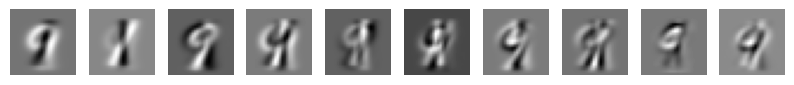

In [314]:
# plot the first principal components
plt.figure(figsize=(10, 10))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(pca.components_[i].reshape(28, 28), cmap="gray")
    plt.axis("off")

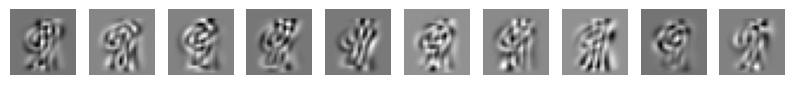

In [315]:
# plot the last principal components
plt.figure(figsize=(10, 10))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(pca.components_[-i - 1].reshape(28, 28), cmap="gray")
    plt.axis("off")

Text(0.5, 1.0, 'MNIST data along the first two principal components')

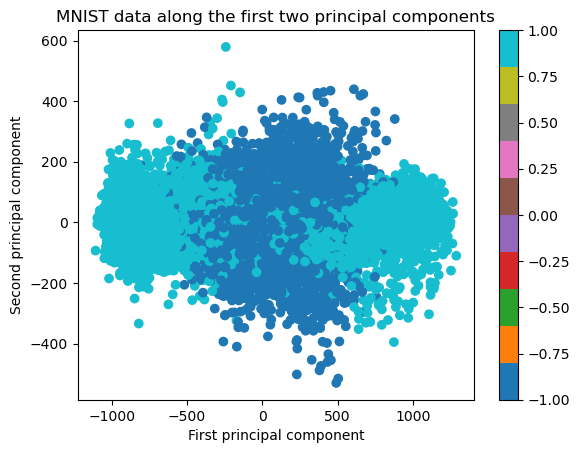

In [316]:
# plot the data along the first two principal components and label it
# plt.figure(figsize=(10, 10))
plt.scatter(pca.transform(mnist_train.data)[:, 1], pca.transform(mnist_train.data)[:, 30], c=mnist_train.targets, cmap="tab10")
plt.colorbar()
plt.xlabel("First principal component")
plt.ylabel("Second principal component")
plt.title("MNIST data along the first two principal components")



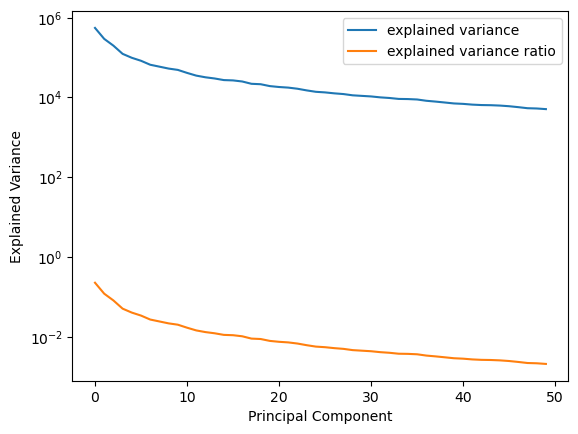

In [317]:
# plot the explained_variance_
# plt.figure(figsize=(10, 10))
plt.plot(pca.explained_variance_, label="explained variance")
plt.plot(pca.explained_variance_ratio_, label="explained variance ratio")
# plt.plot(np.cumsum(pca.explained_variance_ratio_), label="cumulative explained variance ratio")
plt.legend()
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance")
plt.yscale("log")
# plt.xscale("log")
plt.show()

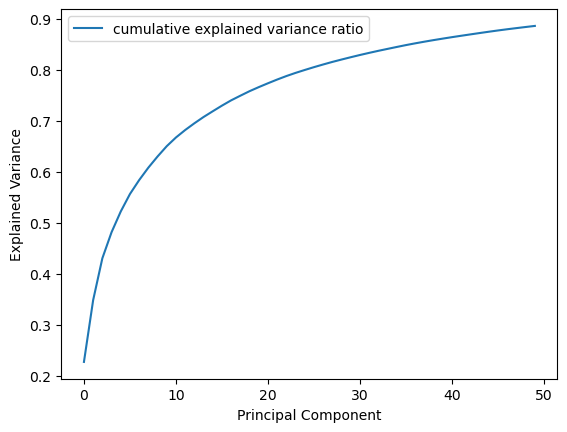

In [318]:
# plot the explained_variance_
# plt.figure(figsize=(10, 10))
plt.plot(np.cumsum(pca.explained_variance_ratio_), label="cumulative explained variance ratio")
plt.legend()
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance")
# plt.yscale("log")
# plt.xscale("log")
plt.show()

In [319]:
# for both the train and test set, transform the data using the PCA
mnist_train.data = pca.transform(mnist_train.data)
mnist_test.data = pca.transform(mnist_test.data)

In [320]:
# make sure data is in numpy
if not isinstance(mnist_train.data, np.ndarray):
    mnist_train.data = mnist_train.data.numpy()
if not isinstance(mnist_test.data, np.ndarray):
    mnist_test.data = mnist_test.data.numpy()
if not isinstance(mnist_train.targets, np.ndarray):
    mnist_train.targets = mnist_train.targets.numpy()
if not isinstance(mnist_test.targets, np.ndarray):
    mnist_test.targets = mnist_test.targets.numpy()

In [374]:
# obtain the dimension of the features
d = mnist_train.data.shape[1]
# sample a blank weight vector
w = np.ones(d)
# create an X vector
X = mnist_train.data
# create a y vector
y = mnist_train.targets
lam = 0.01
epsilon = 100

problem_type = ProblemType.Logistic


In [375]:

sigma_delta_content = np.ones(d)
sigma_delta_content[int(d/2):] = 1.0
print(sigma_delta_content[0],sigma_delta_content[-1])
sigma_delta = np.diag(sigma_delta_content)

weights, _ = sklearn_optimize(w, X, y, lam, epsilon, problem_type,sigma_delta=sigma_delta)

1.0 1.0


In [376]:
# create X_test and y_test
X_test = mnist_test.data
y_test = mnist_test.targets

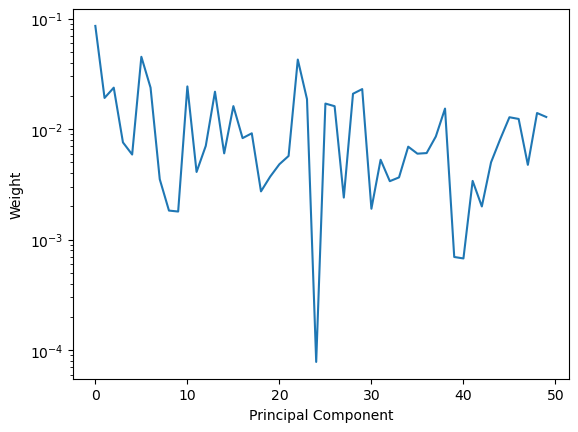

In [377]:
# plot the norm of each component of the weight vector
plt.plot(np.abs(weights))
plt.xlabel("Principal Component")
plt.ylabel("Weight")
plt.yscale("log")
plt.show()

(50,)


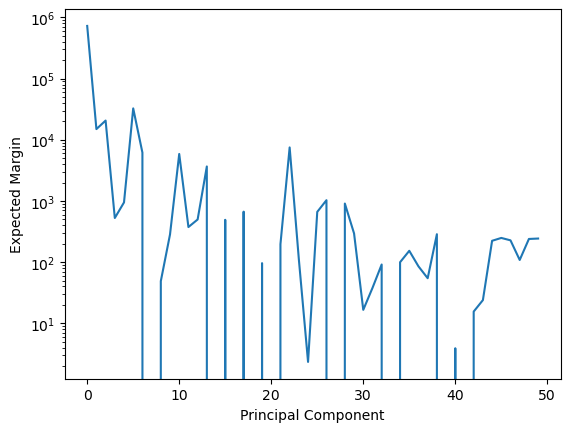

In [378]:
# compute y*X and sum over the data
yX = np.sum(y[:, np.newaxis] * X, axis=0)
print(yX.shape)
# compute elementwise yX * weights
yXw = yX * weights
# plot yXw
plt.plot(yXw)
plt.xlabel("Principal Component")
plt.ylabel("Expected Margin")
plt.yscale("log")
plt.show()


In [379]:
attack_epsilon = 100
sigma_upsilon_trace = np.ones(d)
print(sigma_upsilon_trace[0],sigma_upsilon_trace[-1])
sigma_upsilon = np.diag(sigma_upsilon_trace)

1.0 1.0


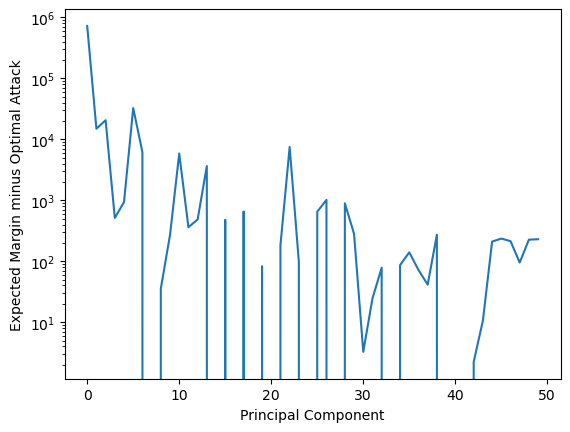

In [380]:
# compute w*sigma_upsilon*w / np.sqrt(w*w)
nww = np.sqrt(weights.dot(weights))
wSw = weights.dot(sigma_upsilon).dot(weights)
optimal_attack = attack_epsilon * wSw / nww
# plot yXw - optimal_attack
plt.plot(yXw - optimal_attack)
plt.xlabel("Principal Component")
plt.ylabel("Expected Margin minus Optimal Attack")
plt.yscale("log")
plt.show()



In [391]:
# create a mask where the expected margin is below 10e2
mask = yXw - optimal_attack < 10e1

In [395]:


sigma_upsilon_trace = np.ones(d)
# sigma_upsilon_trace[:50] = 0.0
print(sigma_upsilon_trace[0],sigma_upsilon_trace[-1])
sigma_upsilon = np.diag(sigma_upsilon_trace)


# set the second half of weights to zero in a copy of it
weights_copy = np.copy(weights)

# put the weights in the copy to zero at the mask
# weights_copy[mask] = 0.0


# compute y pred train
y_pred_train = np.sign(np.dot(X, weights))
# compute y pred test
y_pred_test = np.sign(np.dot(X_test, weights))
# evaluate error and adversarial error
print("training error",error(y_pred_train,y))
print("test error",error(y_pred_test,y_test))


print("adversarial error", adversarial_error(y_test,X_test,weights_copy,attack_epsilon,sigma_upsilon))

1.0 1.0
training error 0.004727759829800646
test error 0.004197761194029851
adversarial error 0.006996268656716418
